# Transfer learning based on online tutorials
This notebook explores transfer learning. 

In [1]:
import datetime
from IPython.display import SVG
from keras import applications
from keras.applications.vgg19 import preprocess_input
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, savefig
import numpy as np
import os
from os import listdir, path
import pydot

/home/peter/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# config
# inline matplotlib's graphs
%matplotlib inline

# to use GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# verify that a gpu is listed
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
# variables
timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# input dir
data_input_dir = 'images/input'
data_train_dir = 'images/train/'
data_validation_dir = 'images/validation/'

# output
output_checkpoint_dir = 'checkpoint/from-tutorial-1.h5'
output_diagram_dir = 'diagram/from-tutorial-1.png'
output_logs_dir = 'logs/{}'.format(timestamp)
output_predictions_dir = 'images/predictions/{}.jpg'.format(timestamp)

# image parameter
input_channels = 3

# model information
n_classes = 3
n_train = 27
n_validation = 3

# hyperparameters
input_height, input_width = 200, 200
batch_size = 16
freeze_layers = 5
epochs = 50

## Create Data Generators
The images should be stored in the following directory structure:  
images:  
   - test:  
       - category_0:  
       - category_1:  
       - category_2:  
       - category_3:  
   - validation:  
       - category_0:  
       - category_1:  
       - category_2:  
       - category_3:        

In [4]:
# define data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   zoom_range=0.3,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                        horizontal_flip=True,
                                        fill_mode='nearest',
                                        zoom_range=0.3,
                                        width_shift_range=0.3,
                                        height_shift_range=0.3,
                                        rotation_range=30)

# initialize them
train_generator = train_datagen.flow_from_directory(data_train_dir,
                                                    target_size=(input_height, input_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(data_validation_dir,
                                                              target_size=(input_height, input_width),
                                                              class_mode='categorical')

Found 82 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


## Prepare Prediction data

In [5]:
# create an array of image paths
base_filenames = listdir(data_input_dir)
filename_paths = [path.join(data_input_dir, base_filename) for base_filename in base_filenames]
filename_paths = np.array(filename_paths)
batch_size = filename_paths.shape[0]

In [6]:
# load the images into a batch
input_batch = np.empty((batch_size, input_height, input_width, input_channels))

for i, filename_path in enumerate(filename_paths):
    input_pil = load_img(filename_path, interpolation='nearest', target_size=(input_height, input_width))
    input_batch[i] = img_to_array(input_pil)

In [7]:
# preprocess the image for the model
preprocessed_input_batch = preprocess_input(input_batch)

In [8]:
# the classes available are
class_dictionary = validation_generator.class_indices
print(class_dictionary)

{'patrick_star': 0, 'sandy_cheeks': 1, 'spongebob': 2}


## Load VGG19

In [9]:
# load the VGG19 network with it's pretrained weights
# include_top refers to the fully connected layers. We don't need this part because we will add our own
# we need to specify the shape of our inputs
model = applications.VGG19(weights='imagenet',
                           include_top=False,
                           input_shape=(input_width, input_height, input_channels))

In [10]:
# examine the loaded model
# we should see that the loaded model has the FC layers + softmax removed
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [11]:
# Freeze the layers we don't want to train. To start, lets freeze all of them... just to see if this works.
for layer in model.layers[:freeze_layers]:
    layer.trainable = False

In [12]:
# examine the layers and check that they are frozen correctly
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f6412934978> False
<keras.layers.convolutional.Conv2D object at 0x7f6412934da0> False
<keras.layers.convolutional.Conv2D object at 0x7f6412934940> False
<keras.layers.pooling.MaxPooling2D object at 0x7f64128e2cf8> False
<keras.layers.convolutional.Conv2D object at 0x7f6412889d30> False
<keras.layers.convolutional.Conv2D object at 0x7f64128ab3c8> True
<keras.layers.pooling.MaxPooling2D object at 0x7f641283ff60> True
<keras.layers.convolutional.Conv2D object at 0x7f6412866898> True
<keras.layers.convolutional.Conv2D object at 0x7f6410110da0> True
<keras.layers.convolutional.Conv2D object at 0x7f6410124710> True
<keras.layers.convolutional.Conv2D object at 0x7f6410138470> True
<keras.layers.pooling.MaxPooling2D object at 0x7f64100e0940> True
<keras.layers.convolutional.Conv2D object at 0x7f641008a438> True
<keras.layers.convolutional.Conv2D object at 0x7f641008ae10> True
<keras.layers.convolutional.Conv2D object at 0x7f64100b7cf8> True
<keras

## Add custom layers

In [13]:
# build our custom layers
# take the output of the loaded model (some x, some y, some c)
x = model.output 

# flatten it so that we can feed it to fully connected layers
x = Flatten(name='flatten')(x)

# feed into a fc layer with a relu activation and output 1024 units
x = Dense(1024, activation='relu', name='fc_1')(x)

# use dropout for a normalizing effect
x = Dropout(0.5, name='do_1')(x)

# feed into a fc layer with a relu activation and output 1024 units
x = Dense(1024, activation='relu', name='fc_2')(x)

# feed into a softmax to make final predictions of n_classes
predictions = Dense(n_classes, activation='softmax', name='prediction')(x)

In [14]:
# create the model
model = Model(input=model.input, output=predictions)

/home/peter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  


In [15]:
# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])

In [16]:
# examine our model with our custom layers.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

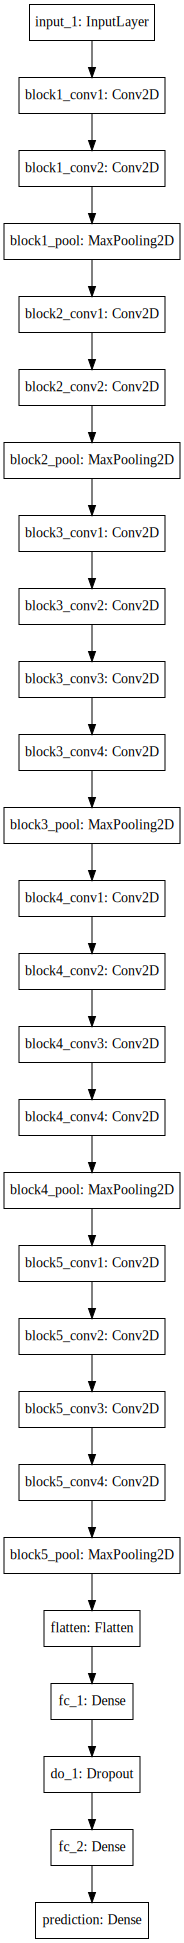

In [17]:
# draw a diagram of the model and save it disk
plot_model(model, to_file=output_diagram_dir)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train model

In [18]:
# Save the model and use early stopping
checkpoint = ModelCheckpoint(output_checkpoint_dir, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_acc', 
                      min_delta=0,
                      patience=10,
                      verbose=1,
                      mode='auto')

tensorboard = TensorBoard(log_dir=output_logs_dir)

In [ ]:
# train the model
model.fit_generator(train_generator,
                    steps_per_epoch=n_train/batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=n_validation,
                    callbacks=[checkpoint, early, tensorboard])

Epoch 1/50
9/9 [==============================] - 9s 1s/step - loss: 1.3850 - acc: 0.2948 - val_loss: 1.0975 - val_acc: 0.3704

Epoch 00001: val_acc improved from -inf to 0.37037, saving model to checkpoint/from-tutorial-1.h5
Epoch 2/50
9/9 [==============================] - 4s 464ms/step - loss: 1.2045 - acc: 0.3791 - val_loss: 1.0190 - val_acc: 0.5185

Epoch 00002: val_acc improved from 0.37037 to 0.51852, saving model to checkpoint/from-tutorial-1.h5
Epoch 3/50
9/9 [==============================] - 4s 474ms/step - loss: 1.0876 - acc: 0.5016 - val_loss: 0.9663 - val_acc: 0.6296

Epoch 00003: val_acc improved from 0.51852 to 0.62963, saving model to checkpoint/from-tutorial-1.h5
Epoch 4/50
9/9 [==============================] - 5s 508ms/step - loss: 1.0824 - acc: 0.4705 - val_loss: 0.8675 - val_acc: 0.8148

Epoch 00004: val_acc improved from 0.62963 to 0.81481, saving model to checkpoint/from-tutorial-1.h5
Epoch 5/50
9/9 [==============================] - 4s 499ms/step - loss: 1.0372

## Make predictions with the model

In [ ]:
# make predictions!
predictions = model.predict(preprocessed_input_batch)

In [ ]:
fig = plt.figure(figsize=(20, 20))
fig.set_facecolor('white')

for i, prediction in enumerate(predictions):
    # decode the predictions
    predictionIndex = np.argmax(prediction)
    predictionBest = round(np.max(prediction) * 100, 4)
    
    # perform a reverse lookup
    className =  next(k for k, v in class_dictionary.items() if v == predictionIndex)
    
    # construct a title
    predictionText = "Prediction " + base_filenames[i] + ": \n" + str(className) + " " + str(predictionBest) + "%"
    
    # view the image that is being predicted
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(input_batch[i]/255)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(predictionText, fontdict={ 'fontsize': 17})
    
savefig(output_predictions_dir)

## References
[Transfer Learning using Keras](https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8)  
[Keras Tutorial: Fine-tuning using pre-trained models](https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/)  
[keras](https://keras.io)  
[deeplearning.ai](https://www.deeplearning.ai/)  